# setup

In [1]:
# import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore', category=UserWarning)  # Suppress user warnings
warnings.filterwarnings('ignore', category=FutureWarning)  # Suppress future warnings

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
# List available GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"GPUs detected: {len(gpus)}")
    for gpu in gpus:
        print(f"GPU Name: {gpu}")
else:
    print("No GPU detected. Running on CPU.")

GPUs detected: 1
GPU Name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# load data

In [4]:
# parameters for loaders
batch_size = 32
image_width = 300
image_height = 300

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "../../datasets/data2.5k",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size
)

Found 2500 files belonging to 5 classes.
Using 2000 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "../../datasets/data2.5k",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 2500 files belonging to 5 classes.
Using 500 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['CBB', 'CBSD', 'CGM', 'CH', 'CMD']


# visualize data

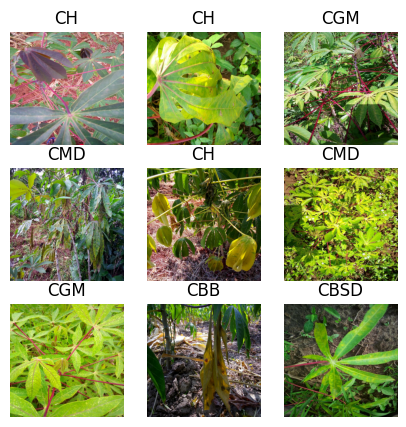

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
   ax = plt.subplot(3, 3, i + 1)
   plt.imshow(images[i].numpy().astype("uint8"))
   plt.title(class_names[labels[i]])
   plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32,)


# augmentation

In [10]:
data_augmentation = keras.Sequential(
  [
   layers.RandomFlip(
      "horizontal",
      input_shape=(image_height, image_width, 3)
   ),
   layers.RandomRotation(0.1),
   layers.RandomZoom(0.1),
  ]
)

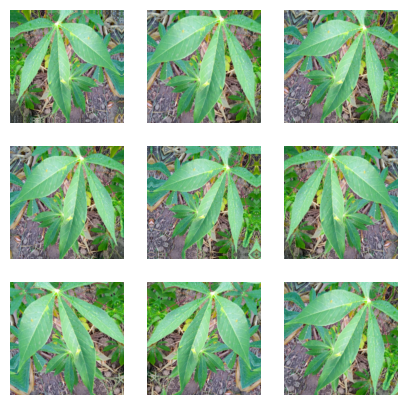

In [11]:
plt.figure(figsize=(5, 5))
for images, _ in train_ds.take(1):
  for i in range(9):
   augmented_images = data_augmentation(images)
   ax = plt.subplot(3, 3, i + 1)
   plt.imshow(augmented_images[0].numpy().astype("uint8"))
   plt.axis("off")

# Configure the dataset for performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# A basic Keras model

In [15]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [16]:
model.compile(
   optimizer='adam',
   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
   metrics=['accuracy'],
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                  

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard_callback]
)

Epoch 1/10
63/63 [==============================] - 13s 201ms/step - loss: 1.8488 - accuracy: 0.1815 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 2/10
63/63 [==============================] - 12s 185ms/step - loss: 1.6096 - accuracy: 0.2000 - val_loss: 1.6074 - val_accuracy: 0.2320
Epoch 3/10
63/63 [==============================] - 12s 188ms/step - loss: 1.6103 - accuracy: 0.1970 - val_loss: 1.6063 - val_accuracy: 0.2780
Epoch 4/10
63/63 [==============================] - 11s 181ms/step - loss: 1.6056 - accuracy: 0.2300 - val_loss: 1.5956 - val_accuracy: 0.2540
Epoch 5/10
63/63 [==============================] - 12s 183ms/step - loss: 1.5966 - accuracy: 0.2375 - val_loss: 1.6054 - val_accuracy: 0.2340
Epoch 6/10
63/63 [==============================] - 12s 183ms/step - loss: 1.5910 - accuracy: 0.2550 - val_loss: 1.5851 - val_accuracy: 0.2500
Epoch 7/10
63/63 [==============================] - 11s 178ms/step - loss: 1.5837 - accuracy: 0.2400 - val_loss: 1.5905 - val_accuracy: 0.2380

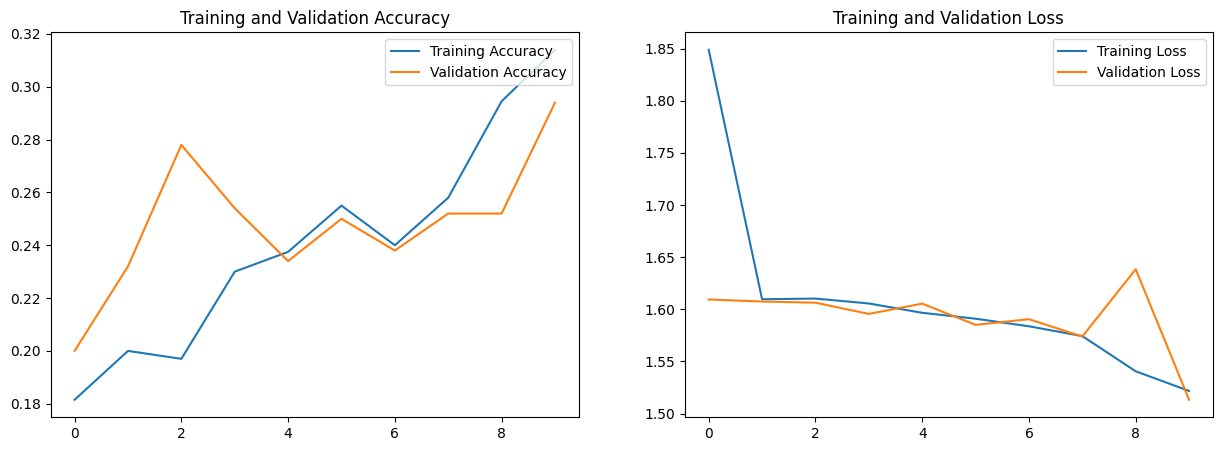

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 16464), started 0:11:17 ago. (Use '!kill 16464' to kill it.)